In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, minmax_scale
from scipy import stats
import warnings
import missingno as msno
import pyod
import math
import sklearn.naive_bayes as nb
import sklearn.svm as svm
from sklearn.metrics import accuracy_score, classification_report
import pickle

# From https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyod.models.combination import average
from pyod.utils.utility import standardizer

warnings.filterwarnings('ignore')
%matplotlib inline

In [18]:
# Welcome to the Build-A-Panda Workshop...
titles = []
traces = []

print("Reading...")
titles.extend(pd.read_pickle("./data_2/titles_vec.pkl"))
traces.extend(pd.read_pickle("./data_2/traces_vec.pkl"))
print("Done")

Reading...
Done


In [19]:
# Generate good/bad data
data: list = []
data_bad: list = []

length: int = len(titles)
for i in range(0, length):
    data.append(titles[i] + traces[i])
    data_bad.append(titles[(i + 1) % length] + traces[i])

In [20]:
# Based on https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
# Create
X: list = []
X.extend(data)
X.extend(data_bad)
length = len(data)
y = [0] * len(X)
for i in range(0, length):
    y[i] = 1

# Standardize
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [21]:
# Training and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
print(len(X_train))

# pca = PCA(2)
# x_pca = pca.fit_transform(X)
# x_pca = pd.DataFrame(x_pca)
# x_pca.columns=['PC1','PC2']
# x_pca.head()
# x_pca.plot(kind='scatter', x='PC1', y='PC2')

1180198


In [22]:
# Train sizes
amt1:int = len(X_train)
amt2:int = math.ceil(amt1 * 0.8)
amt3:int = math.ceil(amt1 * 0.6)

# Build models
print(amt1)
print("Train 1")
clf1 = IForest(behaviour="new", max_samples=amt1)
clf1.fit(X_train)

print("Train 2")
clf2 = IForest(behaviour="new", max_samples=amt2)
clf2.fit(X_train)

print("Train 3")
clf3 = IForest(behaviour="new", max_samples=amt3) 
clf3.fit(X_train)

1180198
Train 1
Train 2
Train 3


IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=708119, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [23]:
# Once again from https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

# Normalize
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

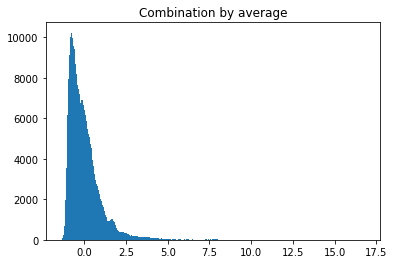

In [24]:
# One more time: from https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
# Combination by average
y_by_average = average(test_scores_norm)

plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()
# Result: 6.25+ is definitely outliers, looks like could be dialed back as far as to 5

In [25]:
# Get copies
cats_avg = average(train_scores_norm)
X_train_cluster = X_train.copy()
y_train_cluster = y_train.copy()

# Apply anomaly scores
X_train_cluster["distance"] = cats_avg
y_train_cluster["distance"] = cats_avg

# Cluster
X_train_cluster = np.where(X_train_cluster['distance']<5, 0, 1)

In [26]:
toDrop: list = []
for i in range(0, len(X_train_cluster) - 1):
    if X_train_cluster[i]:
        toDrop.append(i)

X_train_filtered: list = X_train.drop(X_train.index[toDrop])
y_train_filtered: list = y_train.drop(y_train.index[toDrop])

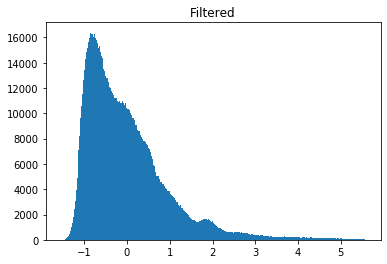

In [27]:
# Verify
train_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_train_filtered),
                              'clf2': clf2.decision_function(X_train_filtered),
                              'clf3': clf3.decision_function(X_train_filtered) 
                            })
y_by_average = average(standardizer(train_scores))

plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Filtered")
plt.show()

In [28]:
# TODO Clean out the other 2/3 of the data set

In [32]:
def train(test, name: str):
    # Train
    train_data = minmax_scale(standardizer(X_train_filtered))
    test.fit(train_data, y_train_filtered)

    # Predict
    test_data = minmax_scale(standardizer(X_test))
    prediction = test.predict(X_test)
    print("===============" + name + "===============\n")
    print('Accuracy:%.2f%%' % (accuracy_score(y_test, prediction) * 100))
    print('Classification Report:')
    print(classification_report(y_test, prediction))

    # Persist classifier to disk
    with open(name, "wb") as out_file:
        pickle.dump(test, out_file)

In [33]:
# Naive Bayes
train(nb.MultinomialNB(), "multinomial.pkl")
train(nb.ComplementNB(), "comp.pkl")
train(nb.BernoulliNB(), "bern.pkl")

# SVMs
# train(svm.SVC(), "svc.pkl")
# train(svm.NuSVC(), "nusvc.pkl")
train(svm.LinearSVC(random_state=42), "linearsvc.pkl")

===============multinomial.pkl===============

Accuracy:49.91%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40    291011
           1       0.50      0.67      0.57    290281

    accuracy                           0.50    581292
   macro avg       0.50      0.50      0.48    581292
weighted avg       0.50      0.50      0.48    581292

===============comp.pkl===============

Accuracy:49.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.34      0.40    291011
           1       0.50      0.66      0.57    290281

    accuracy                           0.50    581292
   macro avg       0.50      0.50      0.49    581292
weighted avg       0.50      0.50      0.49    581292

===============bern.pkl===============

Accuracy:50.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.66      0.57    

In [ ]:
#scatterplot
# sns.set()
# cols = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
# sns.pairplot(panda_data[cols], size = 2.5)
# plt.show();